In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import calendar

In [ ]:
online_sales= pd.read_csv('Online_Sales.csv')
customers_data = pd.read_excel('CustomersData.xlsx')
discount_coupon = pd.read_csv('Discount_Coupon.csv')
marketing_spend = pd.read_csv('Marketing_Spend.csv')
tax_amount = pd.read_excel('tax_amount.xlsx')


In [ ]:
merged_df = pd.merge(online_sales, customers_data, on='CustomerID',how='left')
merged_df['Transaction_Date'] = pd.to_datetime(merged_df['Transaction_Date'])
merged_df['Month_Name'] = merged_df['Transaction_Date'].dt.strftime('%b')

merged_df = pd.merge(merged_df, discount_coupon, left_on=['Product_Category','Month_Name'],right_on=['Product_Category','Month'],how='left')
merged_df.drop('Month', axis=1, inplace=True)

merged_df.Discount_pct.fillna(0, inplace=True)

merged_df = pd.merge(merged_df, tax_amount, on='Product_Category')


1.	Identify the months with the highest and lowest acquisition count. What strategies could be implemented to address the fluctuations and ensure consistent growth throughout the year

In [ ]:
# Acquisition count refers to the number of new customers acquired in a specific period (like a month).

In [ ]:
acquisition_count = merged_df.groupby('CustomerID')['Transaction_Date'].min().reset_index()
acquisition_count['Transaction_Date'] = acquisition_count['Transaction_Date'].dt.strftime('%b')
acquisition_count = acquisition_count.rename(columns={'Transaction_Date':'Month'})
acquisition_count = acquisition_count.value_counts('Month')
acquisition_count = acquisition_count.reset_index(name='count')
acquisition_count


,Month,count
0,Jan,215
1,Mar,177
2,Apr,163
3,Jun,137
4,Aug,135
5,May,112
6,Dec,106
7,Feb,96
8,Jul,94
9,Oct,87


2.	Analyze the data to determine if certain months consistently show higher or lower monthly acquisitions. How can the company capitalize on high-performing months and improve performance during slower periods?

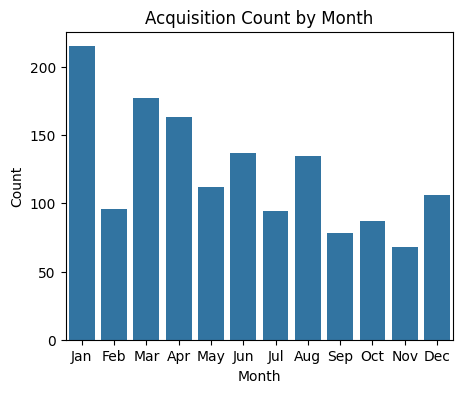

In [ ]:
# Define the desired order of months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a categorical type with the defined order
acquisition_count['Month'] = pd.Categorical(acquisition_count['Month'], categories=month_order, ordered=True)

# Sort the dataframe by the ordered month column
acquisition_count = acquisition_count.sort_values('Month')

# Create the bar plot
plt.figure(figsize=(5, 4))
sns.barplot(x='Month', y='count', data=acquisition_count)

# Add title and labels
plt.title('Acquisition Count by Month')
plt.xlabel('Month')
plt.ylabel('Count')

# Show the plot
plt.show()

3.	Identify periods with the strongest and weakest retention rates. What strategies could be implemented to improve retention during weaker months?

In [ ]:
# The retention rate is the percentage of existing customers
# who continue buying in the next period (e.g., next month).

In [ ]:
df = merged_df
df['Month'] = df['Transaction_Date'].dt.to_period('M')
monthly_customers = df.groupby('Month')['CustomerID'].unique().to_dict()

# Step 2: Retention calculation
retention_rates = {}
months = sorted(monthly_customers.keys())

for i in range(len(months) - 1):
    current_month = months[i]
    next_month = months[i + 1]

    customers_current = set(monthly_customers[current_month])
    customers_next = set(monthly_customers[next_month])

    retained = customers_current.intersection(customers_next)
    retention_rates[current_month] = len(retained)


df_retention = pd.DataFrame(list(retention_rates.items()), columns=['Month', 'RetainedCustomers'])


# # Optional: sort by month
df_retention = df_retention.sort_values('Month').reset_index(drop=True)
df_retention['Month'] = df_retention['Month'].dt.to_timestamp().dt.strftime('%b')


customers_permonth = df.groupby('Month')['CustomerID'].nunique().reset_index()
customers_permonth.columns = ['Month', 'TotalCustomers']
df_retention['Retention_Rate'] = df_retention['RetainedCustomers']*100 / customers_permonth['TotalCustomers']
df_retention['Total_Customers'] = customers_permonth['TotalCustomers']
df_retention


,Month,RetainedCustomers,Retention_Rate,Total_Customers
0,Jan,13,6.046512,215
1,Feb,11,10.091743,109
2,Mar,24,11.538462,208
3,Apr,25,11.160714,224
4,May,37,18.500000,200
5,Jun,58,22.393822,259
6,Jul,65,27.542373,236
7,Aug,44,14.666667,300
8,Sep,29,15.025907,193
9,Oct,31,14.761905,210


4.	Analyze customer behavior during high-retention months and suggest ways to replicate this success throughout the year.



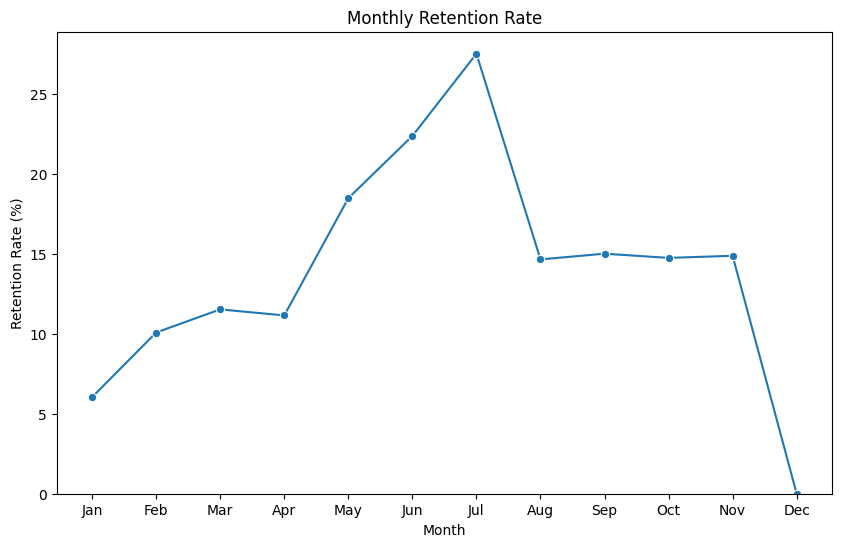

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

df_plot = pd.DataFrame({'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                       'Retention_Rate': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]})

for index, row in df_retention.iterrows():
    df_plot.loc[df_plot['Month'] == row['Month'], 'Retention_Rate'] = row['Retention_Rate']

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_plot['Month'] = pd.Categorical(df_plot['Month'], categories=month_order, ordered=True)
df_plot = df_plot.sort_values('Month')

if 'Dec' not in df_plot['Month'].values:
    df_plot = df_plot.append({'Month': 'Dec', 'Retention_Rate': 0}, ignore_index=True)
    df_plot['Month'] = pd.Categorical(df_plot['Month'], categories=month_order, ordered=True)
    df_plot = df_plot.sort_values('Month')


plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot, x='Month', y='Retention_Rate', marker='o')

plt.ylim(bottom=0)

plt.title('Monthly Retention Rate')
plt.xlabel('Month')
plt.ylabel('Retention Rate (%)')

plt.show()

5.	Compare the revenue generated by new and existing customers month-over-month. What does this trend suggest about the balance between acquisition and retention efforts?

In [ ]:
merged_df['invoice_value'] = ((merged_df.Avg_Price * merged_df.Quantity)*(1 - (merged_df.Discount_pct/100))*(1 + merged_df.GST)) + merged_df.Delivery_Charges
revenue = merged_df
first_purchase = revenue.groupby('CustomerID')['Transaction_Date'].min().dt.to_period('M')

revenue['Customer_First_Month'] = revenue['CustomerID'].map(first_purchase)

revenue['Customer_Type'] = revenue.apply(lambda x: 'New' if x['Month'] == x['Customer_First_Month'] else 'Existing', axis=1)

monthly_revenue1 = revenue.groupby(['Month', 'Customer_Type'])['invoice_value'].sum().unstack()
monthly_revenue1


Customer_Type,Existing,New
Month,,
2019-01,NaN,463883.05705
2019-02,41053.61768,286842.94252
2019-03,57181.70852,279623.49531
2019-04,183188.12296,264811.07227
2019-05,115067.71388,203488.58668
2019-06,116949.70571,172880.62360
2019-07,254868.57578,169113.76783
2019-08,217630.89804,200529.66900
2019-09,188985.49823,132142.85815


6.	Analyze the relationship between coupon usage and revenue generation. How can discount strategies be optimized to maximize revenue while maintaining profitability?

In [ ]:
merged_df['revenue'] = ((merged_df.Avg_Price * merged_df.Quantity)*(1 - (merged_df.Discount_pct/100)))
coupon_revenue = merged_df.groupby('Coupon_Status')['revenue'].sum().round(0).reset_index()
coupon_revenue


,Coupon_Status,revenue
0,Clicked,1909153.0
1,Not Used,585638.0
2,Used,1250046.0


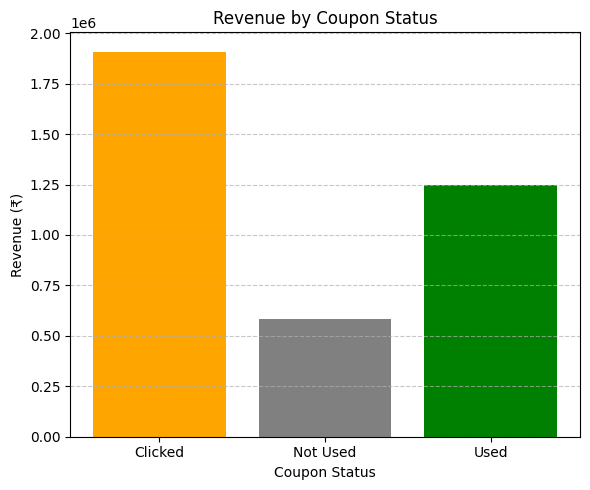

In [ ]:
plt.figure(figsize=(6,5))
plt.bar(coupon_revenue['Coupon_Status'], coupon_revenue['revenue'], color=['orange', 'gray', 'green'])
plt.title('Revenue by Coupon Status')
plt.xlabel('Coupon Status')
plt.ylabel('Revenue (₹)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

7.	Identify the top-performing products and analyze the factors driving their success. How can this insight inform inventory management and promotional strategies?

In [ ]:
top_products = merged_df.groupby('Product_Category')['revenue'].sum().sort_values(ascending=False).reset_index()
top_products.head(5)

,Product_Category,revenue
0,Nest-USA,2046977.708
1,Apparel,473377.963
2,Nest,403708.746
3,Office,223229.256
4,Drinkware,161135.231


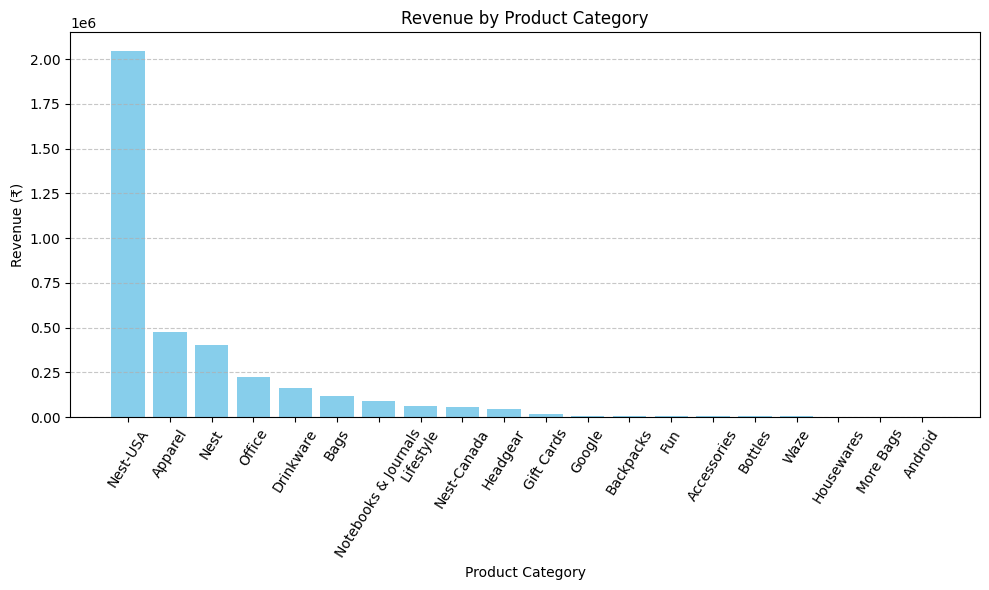

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(top_products['Product_Category'],top_products['revenue'], color='skyblue')
plt.title('Revenue by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Revenue (₹)')
plt.xticks(rotation=58)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
top_products = merged_df.groupby('Product_Description')['revenue'].sum().sort_values(ascending=False).reset_index()
top_products.head(5)

,Product_Description,revenue
0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,553467.511
1,Nest Cam Outdoor Security Camera - USA,504229.528
2,Nest Cam Indoor Security Camera - USA,424759.777
3,Nest Protect Smoke + CO White Battery Alarm-USA,172039.684
4,Nest Protect Smoke + CO White Wired Alarm-USA,170945.141


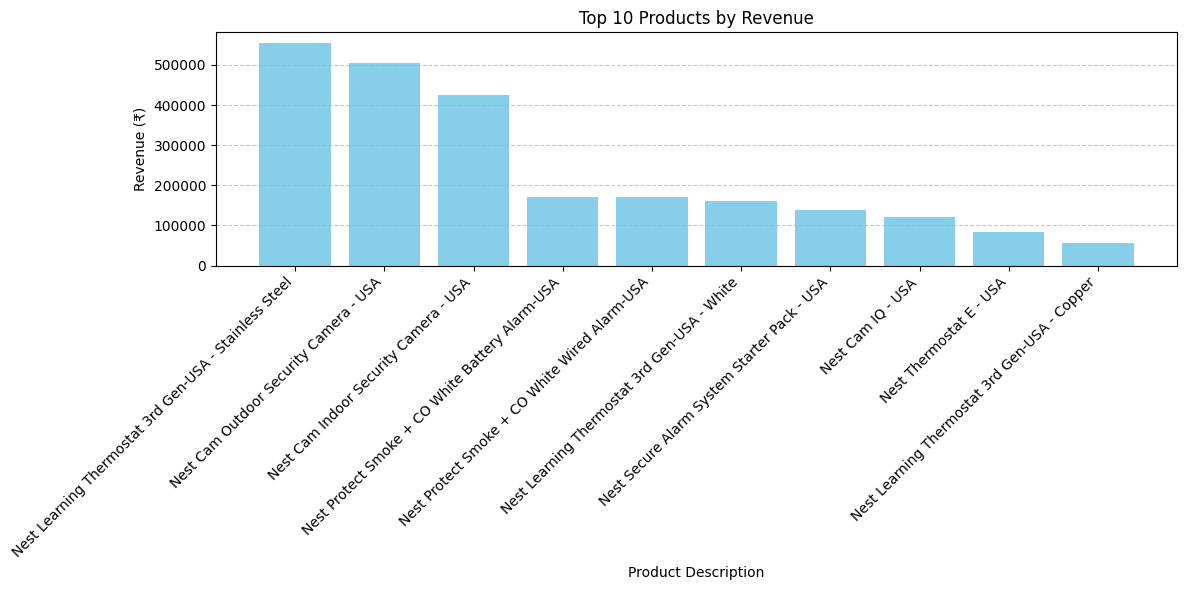

In [ ]:
# Group by Product Description (not Category), then sort by revenue
top_products = df.groupby('Product_Description')['revenue'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(top_products.index, top_products.values, color='skyblue')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Product Description')
plt.ylabel('Revenue (₹)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


8.	Analyze the relationship between monthly marketing spend and revenue. Are there any months where marketing efforts yielded disproportionately high or low returns? How can marketing strategies be adjusted to improve ROI?

In [ ]:

marketing_spend['Date'] = pd.to_datetime(marketing_spend['Date'])
marketing_spend['Month_Name'] = marketing_spend['Date'].dt.strftime('%b')


In [ ]:
marketing_spend['Total_Spend'] = marketing_spend['Offline_Spend'] + marketing_spend['Online_Spend']

monthly_marketingspend = marketing_spend.groupby('Month_Name')['Total_Spend'].sum().reset_index()
monthly_revenue = merged_df.groupby('Month_Name')['revenue'].sum().reset_index().round(2)

revenue_vs_marketing = pd.merge(monthly_revenue, monthly_marketingspend, on='Month_Name', how='left')

# Sorting by Month Name
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

revenue_vs_marketing['Month_Name'] = pd.Categorical(
    revenue_vs_marketing['Month_Name'],
    categories=month_order,
    ordered=True
)

revenue_vs_marketing = revenue_vs_marketing.sort_values('Month_Name')
revenue_vs_marketing = revenue_vs_marketing.reset_index(drop=True)
revenue_vs_marketing

,Month_Name,revenue,Total_Spend
0,Jan,363519.10,154928.95
1,Feb,249155.07,137107.92
2,Mar,245902.07,122250.09
3,Apr,361934.00,157026.83
4,May,246972.06,118259.64
5,Jun,225356.86,134318.14
6,Jul,335686.71,120217.85
7,Aug,321321.16,142904.15
8,Sep,252609.23,135514.54
9,Oct,368873.29,151224.65


9.	Evaluate the effectiveness of marketing campaigns by comparing marketing spend to revenue generated. Are there opportunities to reallocate resources for better results?

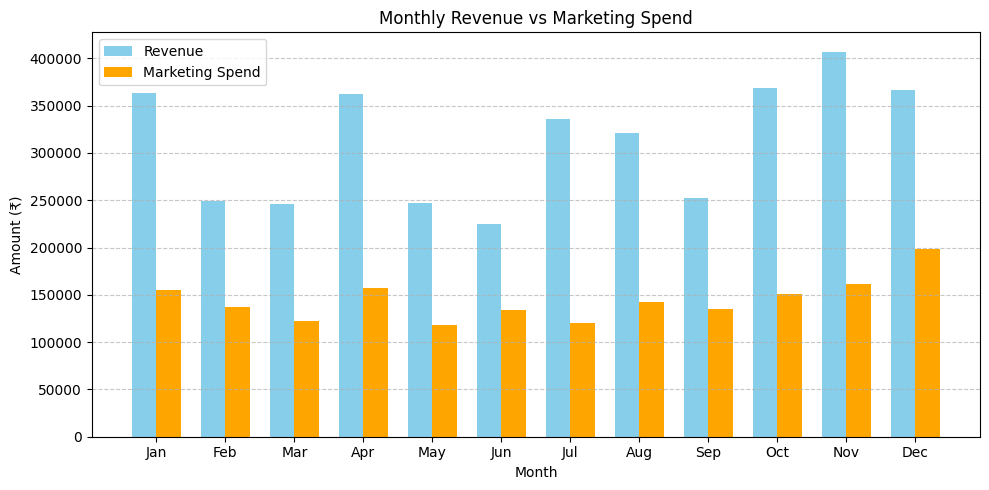

In [ ]:
x = np.arange(len(revenue_vs_marketing['Month_Name']))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, revenue_vs_marketing['revenue'], width, label='Revenue', color='skyblue')
plt.bar(x + width/2, revenue_vs_marketing['Total_Spend'], width, label='Marketing Spend', color='orange')

plt.xlabel('Month')
plt.ylabel('Amount (₹)')
plt.title('Monthly Revenue vs Marketing Spend')
plt.xticks(x, revenue_vs_marketing['Month_Name'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

10.	Segment customers into groups such as Premium, Gold, Silver, and Standard. What targeted strategies can be developed for each segment to improve retention and revenue? (Use RFM segmentation techniques)

In [ ]:
today = pd.to_datetime('2019-12-31')
rfm = merged_df.groupby('CustomerID').agg({
    'Transaction_Date': lambda x: (today - x.max()).days,
    'Transaction_ID': 'count',
    'revenue': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


r_bins = [0,100,200,300,np.inf]
f_bins = [0,200,400,600,np.inf]
m_bins = [0,15000,30000,45000,np.inf]

rfm['R_Score'] = pd.cut(rfm['Recency'], bins=r_bins, labels=[4,3,2,1] ,include_lowest=True).astype(int)
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=f_bins, labels=[1,2,3,4],include_lowest=True).astype(int)
rfm['M_Score'] = pd.cut(rfm['Monetary'], bins=m_bins, labels=[1,2,3,4],include_lowest=True).astype(int)

rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

def classify_customer(score):
    if score <= 5:
        return 'Standard'
    elif score <= 6:
        return 'Silver'
    elif score <= 9:
        return 'Gold'
    else:
        return 'Premium'

rfm['Segment'] = rfm['RFM_Score'].apply(classify_customer)

rfm_merged = merged_df.copy
rfm_merged = merged_df.merge(rfm[['CustomerID', 'RFM_Score','Segment']], on='CustomerID', how='left')
rfm_merged
# rfm

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,...,Coupon_Code,Discount_pct,GST,Month,invoice_value,Customer_First_Month,Customer_Type,revenue,RFM_Score,Segment
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,ELEC10,10.0,0.10,2019-01,158.67290,2019-01,New,138.339,6,Silver
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,ELEC10,10.0,0.10,2019-01,158.67290,2019-01,New,138.339,6,Silver
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,...,OFF10,10.0,0.10,2019-01,8.52950,2019-01,New,1.845,6,Silver
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,...,SALE10,10.0,0.18,2019-01,99.58430,2019-01,New,78.885,6,Silver
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,...,AIO10,10.0,0.18,2019-01,24.02300,2019-01,New,14.850,6,Silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,2019-12-31,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked,...,ELEC30,30.0,0.10,2019-12,99.90100,2019-12,New,84.910,6,Silver
52920,14410,48494,2019-12-31,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used,...,SALE30,30.0,0.18,2019-12,46.90792,2019-12,New,34.244,6,Silver
52921,14410,48495,2019-12-31,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used,...,ELEC30,30.0,0.10,2019-12,123.44760,2019-12,New,106.316,6,Silver
52922,14600,48496,2019-12-31,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked,...,ELEC30,30.0,0.10,2019-12,316.50200,2019-12,New,281.820,6,Silver


Text(0.5, 0, 'RFM Score')

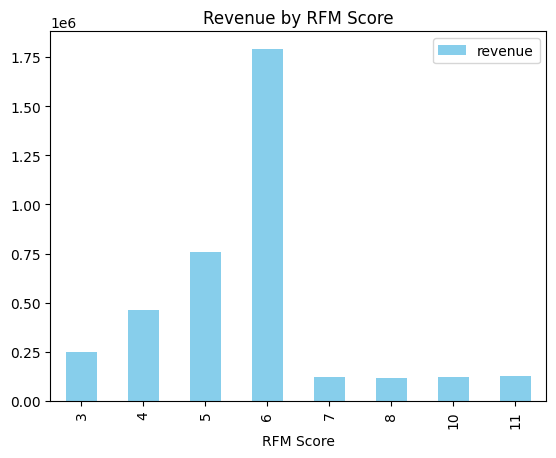

In [ ]:
rfm_merged.groupby('RFM_Score')['revenue'].sum().reset_index().plot(kind='bar', x='RFM_Score', y='revenue', color='skyblue')
plt.title('Revenue by RFM Score')
plt.xlabel('RFM Score')

11.	Analyze the revenue contribution of each customer segment. How can the company focus its efforts on high-value segments while nurturing lower-value segments?

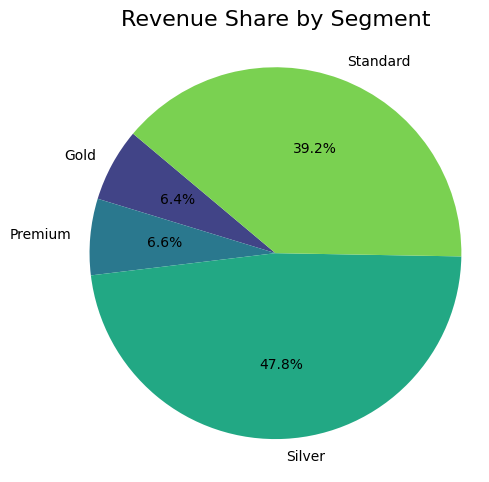

In [ ]:
segments_revenue = rfm_merged.groupby('Segment')['revenue'].sum().reset_index()

# Pie chart
plt.figure(figsize=(5, 5))
plt.pie(
    segments_revenue['revenue'],
    labels=segments_revenue['Segment'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('viridis', len(segments_revenue))
)

# Title
plt.title('Revenue Share by Segment', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle.

plt.tight_layout()
plt.show()


12.	Group customers by their month of first purchase and analyze retention rates over time. Which cohorts exhibit the highest and lowest retention rates? What strategies can be implemented to improve retention for weaker cohorts?

In [ ]:
# Convert CustomerID to string to avoid merge issues
df['CustomerID'] = df['CustomerID'].astype(str)

# Create first purchase month for each customer
first_purchase = df.groupby('CustomerID')['Transaction_Date'].min().reset_index()
first_purchase['first_purchase_month'] = first_purchase['Transaction_Date'].dt.strftime('%b')
first_purchase = first_purchase[['CustomerID', 'first_purchase_month']]

# Merge with original data
df['Transaction_Month'] = df['Transaction_Date'].dt.strftime('%b')
first_purchase['CustomerID'] = first_purchase['CustomerID'].astype(str)
cohort_data = pd.merge(df, first_purchase, on='CustomerID', how='left')

# Count unique customers in each cohort vs transaction month
cohort_counts = cohort_data.groupby(['first_purchase_month', 'Transaction_Month'])['CustomerID'].nunique().reset_index()

# Pivot to create matrix
cohort_matrix = cohort_counts.pivot_table(index='first_purchase_month',
                                          columns='Transaction_Month',
                                          values='CustomerID')

# convert month names to numbers for better sorting
cohort_matrix.index = cohort_matrix.index.map(lambda x: datetime.strptime(x[:3], '%b').month)
cohort_matrix.columns = cohort_matrix.columns.map(lambda x: datetime.strptime(x[:3], '%b').month)

# Sort and clean
cohort_matrix.sort_index(inplace=True)
cohort_matrix.sort_index(axis=1, inplace=True)
cohort_matrix = cohort_matrix.fillna(0)

# Final Output
cohort_matrix

Transaction_Month,1,2,3,4,5,6,7,8,9,10,11,12
first_purchase_month,,,,,,,,,,,,
1,215.0,13.0,24.0,34.0,23.0,44.0,35.0,47.0,23.0,28.0,20.0,34.0
2,0.0,96.0,7.0,9.0,16.0,17.0,22.0,19.0,15.0,12.0,11.0,16.0
3,0.0,0.0,177.0,18.0,35.0,25.0,32.0,33.0,22.0,22.0,15.0,19.0
4,0.0,0.0,0.0,163.0,14.0,24.0,24.0,18.0,15.0,10.0,16.0,12.0
5,0.0,0.0,0.0,0.0,112.0,12.0,9.0,13.0,10.0,13.0,14.0,8.0
6,0.0,0.0,0.0,0.0,0.0,137.0,20.0,22.0,12.0,11.0,14.0,11.0
7,0.0,0.0,0.0,0.0,0.0,0.0,94.0,13.0,4.0,6.0,11.0,9.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.0,14.0,15.0,10.0,8.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,6.0,3.0,2.0


13.	Analyze the lifetime value of customers acquired in different months. How can this insight inform acquisition and retention strategies?

In [ ]:
Total_revenue = merged_df.groupby('CustomerID')['revenue'].sum().reset_index()
first_purchase_revenue = pd.merge(Total_revenue, first_purchase, on='CustomerID', how='left')

average_revenue = first_purchase_revenue.groupby('first_purchase_month')['revenue'].sum().round(2).reset_index()
average_revenue.columns = ['Month', 'Average_LT_Revenue']

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
average_revenue['Month'] = pd.Categorical(average_revenue['Month'], categories=month_order, ordered=True)
average_revenue = average_revenue.sort_values('Month')

average_revenue

,Month,Average_LT_Revenue
4,Jan,872533.22
3,Feb,427686.53
7,Mar,507753.27
0,Apr,381211.90
8,May,267876.37
6,Jun,214494.80
5,Jul,205311.86
1,Aug,205742.96
11,Sep,106949.78
10,Oct,205568.94


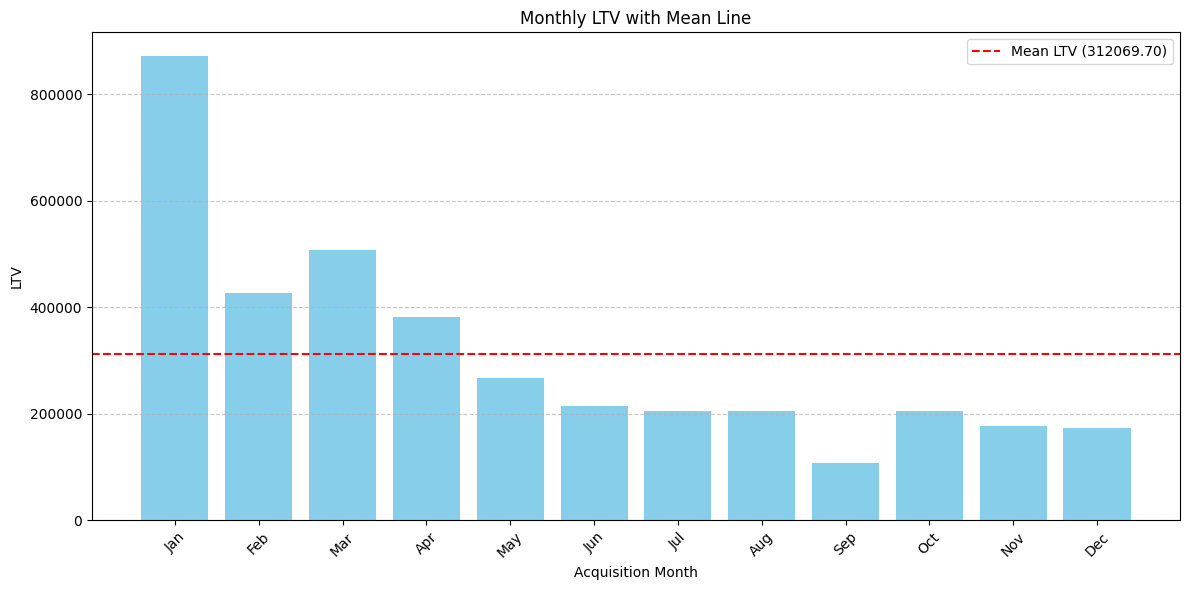

In [ ]:
plt.figure(figsize=(12, 6))
bars = plt.bar(average_revenue['Month'], average_revenue['Average_LT_Revenue'], color='skyblue')

mean_ltv = average_revenue['Average_LT_Revenue'].mean()

# Add horizontal line for mean
plt.axhline(y=mean_ltv, color='red', linestyle='--', label=f'Mean LTV ({mean_ltv:.2f})')

# Labels and title
plt.xlabel('Acquisition Month')
plt.ylabel('LTV')
plt.title('Monthly LTV with Mean Line')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

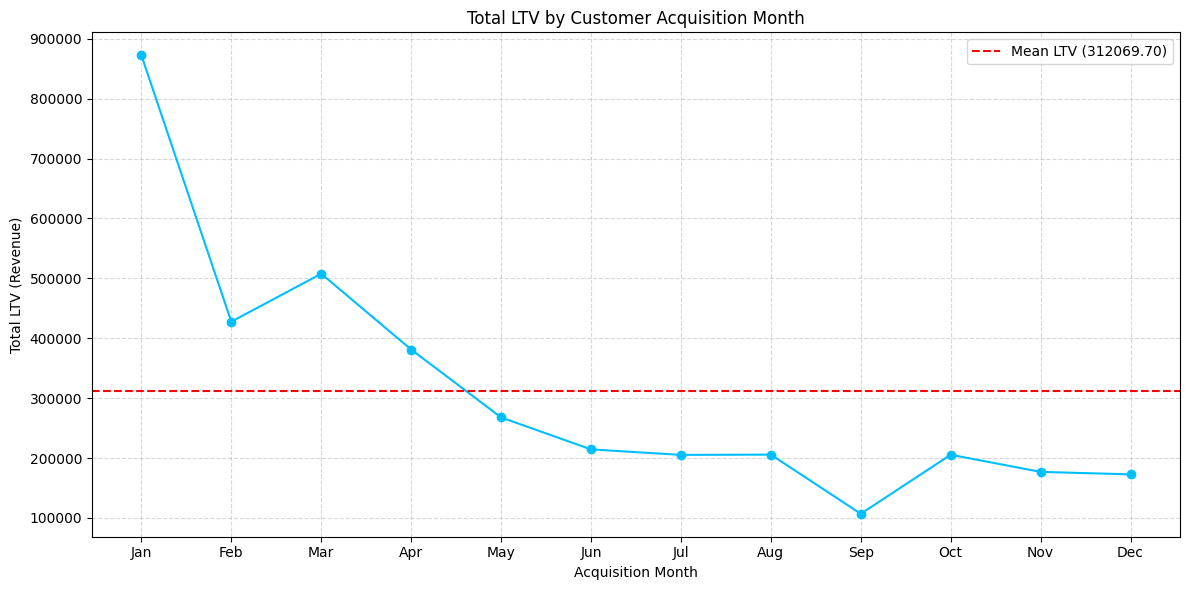

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(average_revenue['Month'], average_revenue['Average_LT_Revenue'],
         marker='o', color='deepskyblue', linestyle='-')

# Add mean line
plt.axhline(y=mean_ltv, color='red', linestyle='--', label=f'Mean LTV ({mean_ltv:.2f})')

# Titles and labels
plt.title('Total LTV by Customer Acquisition Month')
plt.xlabel('Acquisition Month')
plt.ylabel('Total LTV (Revenue)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

14.	Do customers who use coupons have a different average transaction value compared to those who do not?Conduct a statistical test to validate this hypothesis. What implications does this have for the company’s discount and coupon strategies?

In [ ]:
merged_df.groupby('Coupon_Status')['revenue'].mean().round(2)

,revenue
Coupon_Status,
Clicked,70.90
Not Used,72.35
Used,69.82


In [ ]:
# H0 = Mean_of_couponused = Mean_of_couponnotused
# Ha = Mean_of_couponused != Mean_of_couponnotused

In [ ]:
used_coupon = merged_df[merged_df['Coupon_Status'] == 'Used']['revenue']
notused_coupon = merged_df[merged_df['Coupon_Status'] == 'Not Used']['revenue']

used_samples = used_coupon.sample(300,random_state=1)
notused_samples = notused_coupon.sample(300,random_state=1)

In [ ]:
# Equal Variance constarint checking using Levene Test
from scipy.stats import levene
levene_test = levene(used_samples, notused_samples)

equal_var = levene_test.pvalue > 0.05
if equal_var:
    print("The variances are equal.")
else:
    print("The variances are not equal.")
#hence p_value > 0.05 the variance of this is approximately equal

The variances are equal.


In [ ]:
from scipy import stats

t_stat, p_value = stats.ttest_ind(used_samples, notused_samples)

print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: -0.6878776535874167
P-value: 0.49179655247089404


In [ ]:
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference.")
else:
    print("Fail to reject the null hypothesis: No significant difference.")

Fail to reject the null hypothesis: No significant difference.


15. Evaluate how taxes and delivery charges influence customer spending behavior. Are there opportunities to adjust pricing strategies to improve customer satisfaction and revenue?

In [ ]:
df

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,...,Month_Name,Coupon_Code,Discount_pct,GST,Month,invoice_value,Customer_First_Month,Customer_Type,revenue,Transaction_Month
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,Jan,ELEC10,10.0,0.10,2019-01,158.67290,2019-01,New,138.339,Jan
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,Jan,ELEC10,10.0,0.10,2019-01,158.67290,2019-01,New,138.339,Jan
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,...,Jan,OFF10,10.0,0.10,2019-01,8.52950,2019-01,New,1.845,Jan
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,...,Jan,SALE10,10.0,0.18,2019-01,99.58430,2019-01,New,78.885,Jan
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,...,Jan,AIO10,10.0,0.18,2019-01,24.02300,2019-01,New,14.850,Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,2019-12-31,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked,...,Dec,ELEC30,30.0,0.10,2019-12,99.90100,2019-12,New,84.910,Dec
52920,14410,48494,2019-12-31,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used,...,Dec,SALE30,30.0,0.18,2019-12,46.90792,2019-12,New,34.244,Dec
52921,14410,48495,2019-12-31,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used,...,Dec,ELEC30,30.0,0.10,2019-12,123.44760,2019-12,New,106.316,Dec
52922,14600,48496,2019-12-31,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked,...,Dec,ELEC30,30.0,0.10,2019-12,316.50200,2019-12,New,281.820,Dec


In [ ]:
df['Delivery_Charges'].describe()

bins = [0, 50, 200, 521]
labels = ['Low Charge', 'Medium Charge', 'High Charge']

# Apply binning
df['charge_category'] = pd.cut(df['Delivery_Charges'], bins=bins, labels=labels, right=True)


In [ ]:
df[(df['Delivery_Charges'] >= 50) & (df['Delivery_Charges'] <= 100)]

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,...,Coupon_Code,Discount_pct,GST,Month,invoice_value,Customer_First_Month,Customer_Type,revenue,Transaction_Month,charge_category
284,17850,16885,2019-01-03,GGOEGDHQ015399,26 oz Double Wall Insulated Bottle,Drinkware,26,19.83,74.74,Not Used,...,EXTRA10,10.0,0.18,2019-01,622.28596,2019-01,New,464.022,Jan,Medium Charge
285,17850,16885,2019-01-03,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,5,1.64,74.74,Clicked,...,OFF10,10.0,0.10,2019-01,82.85800,2019-01,New,7.380,Jan,Medium Charge
286,17850,16885,2019-01-03,GGOEGFKQ020799,Google Doodle Decal,Office,3,2.89,74.74,Clicked,...,OFF10,10.0,0.10,2019-01,83.32330,2019-01,New,7.803,Jan,Medium Charge
287,17850,16885,2019-01-03,GGOEYFKQ020699,YouTube Custom Decals,Office,5,1.64,74.74,Clicked,...,OFF10,10.0,0.10,2019-01,82.85800,2019-01,New,7.380,Jan,Medium Charge
288,17850,16885,2019-01-03,GGOEYOLR018699,YouTube Leatherette Notebook Combo,Office,26,5.55,74.74,Clicked,...,OFF10,10.0,0.10,2019-01,217.59700,2019-01,New,129.870,Jan,Medium Charge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51009,17337,47057,2019-12-15,GGOEGDHC087099,Google Thermal Bottle Blue,Drinkware,2,24.45,75.00,Not Used,...,EXTRA30,30.0,0.18,2019-12,115.39140,2019-12,New,34.230,Dec,Medium Charge
51010,17337,47057,2019-12-15,GGOEGDHH087299,Google Thermal Bottle Green,Drinkware,2,24.45,75.00,Clicked,...,EXTRA30,30.0,0.18,2019-12,115.39140,2019-12,New,34.230,Dec,Medium Charge
51011,17337,47057,2019-12-15,GGOEGDHR086999,Google Thermal Bottle Red,Drinkware,1,24.45,75.00,Not Used,...,EXTRA30,30.0,0.18,2019-12,95.19570,2019-12,New,17.115,Dec,Medium Charge
51012,17337,47057,2019-12-15,GGOEGDHT087199,Google Thermal Bottle Yellow,Drinkware,1,24.45,75.00,Clicked,...,EXTRA30,30.0,0.18,2019-12,95.19570,2019-12,New,17.115,Dec,Medium Charge


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
samp_df = df.sample(500)
# Assuming df has columns: 'Invoice_Value' and 'GST'
model = smf.ols("invoice_value ~ GST", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          invoice_value   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     4668.
Date:                Tue, 16 Sep 2025   Prob (F-statistic):               0.00
Time:                        12:19:37   Log-Likelihood:            -3.3892e+05
No. Observations:               52924   AIC:                         6.778e+05
Df Residuals:                   52922   BIC:                         6.779e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    219.3309      2.009    109.150      0.0

16. Identify seasonal trends in sales by category and location. How can the company prepare for peak and off-peak seasons to maximize revenue?

In [ ]:
# Count transactions per Location × Category × Month
trend_data = (
    df.groupby(["Location", "Product_Category", "Month_Name"])
    .size()
    .reset_index(name="Sales_Count")
)

# print(trend_data)

In [ ]:
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])

df['Month_Name'] = df['Transaction_Date'].dt.month_name()

# Keep calendar order for months
month_order = list(calendar.month_name)[1:]
df['Month_Name'] = pd.Categorical(
    df['Month_Name'], categories=month_order, ordered=True
)

pivot_table = pd.pivot_table(
    df,
    values="Product_SKU",
    index=["Location", "Product_Category"],
    columns="Month_Name",
    aggfunc="count",
    fill_value=0
)

# print(pivot_table)

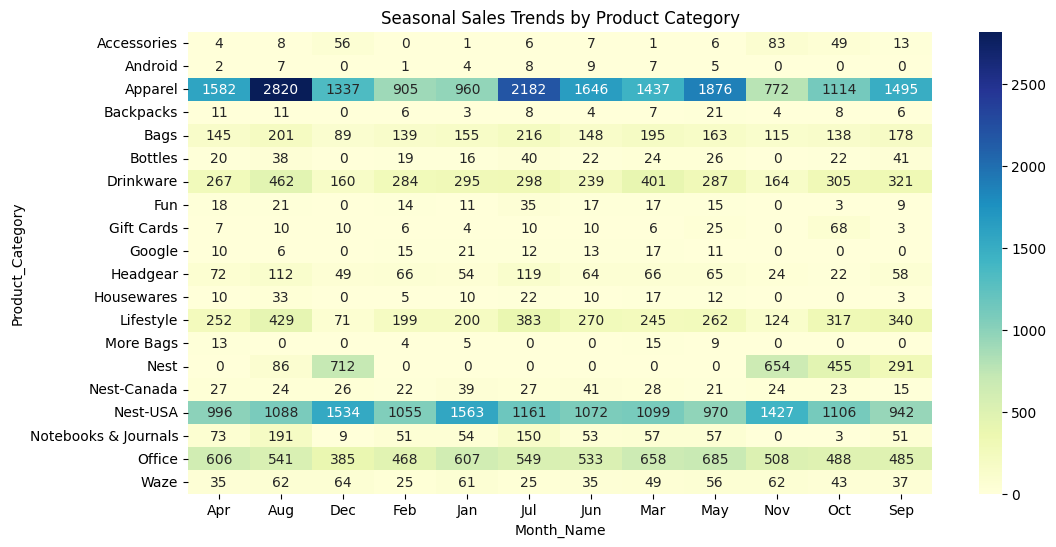

In [ ]:
plt.figure(figsize=(12,6))
heatmap_data = trend_data.pivot_table(
    values="Sales_Count",
    index="Product_Category",
    columns="Month_Name",
    aggfunc="sum",
    fill_value=0
)
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Seasonal Sales Trends by Product Category")
plt.show()


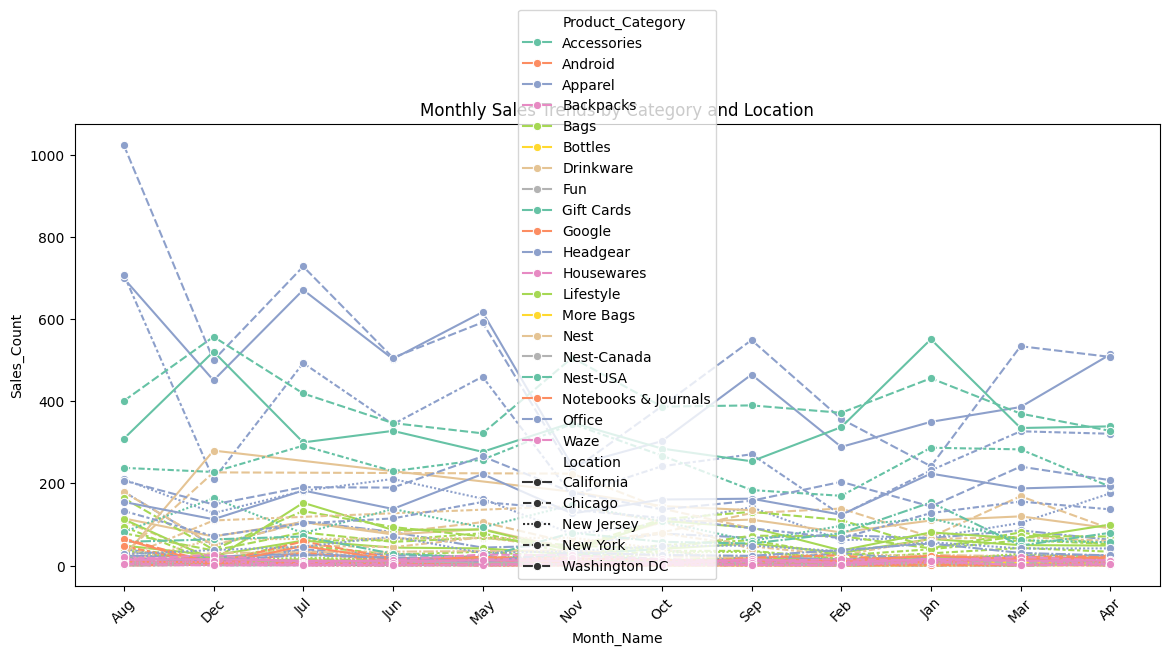

In [ ]:
plt.figure(figsize=(14,6))
sns.lineplot(
    data=trend_data,
    x="Month_Name", y="Sales_Count",
    hue="Product_Category", style="Location", marker="o",
    palette="Set2"
)
plt.xticks(rotation=45)
plt.title("Monthly Sales Trends by Category and Location")
plt.show()


17. Analyze daily sales trends to identify high-performing and low-performing days. What strategies can be implemented to boost sales on slower days?

In [ ]:
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])
df['Day_of_Week'] = df['Transaction_Date'].dt.day_name()

df.groupby('Day_of_Week')['revenue'].sum().reset_index()

,Day_of_Week,revenue
0,Friday,696919.064
1,Monday,290776.423
2,Saturday,540279.082
3,Sunday,552251.303
4,Thursday,682588.259
5,Tuesday,319194.580
6,Wednesday,662827.666
